In [1]:
import numpy as np
import xarray as xr
from dotenv import load_dotenv
from matplotlib import cm
import os
import ac3airborne
import matplotlib.pyplot as plt
import typhon as ty
import src
import glob

# use typhon ploting style
plt.style.use(ty.plots.styles.get('typhon'))

/net/secaire/mringel/.conda/envs/ac3env/lib/python3.10/site-packages/typhon/nonlte/rtc/__init__.py:9: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def FOSC(tau, Sb, Sm, Ib):


In [2]:
cat, meta, credentials, kwds = src.get_ac3_meta()

In [3]:
flight = meta['ACLOUD']['P5']['ACLOUD_P5_RF05']

try:
    miraca_all = cat['ACLOUD']['P5']['MiRAC-A']['ACLOUD_P5_RF05'](**credentials,storage_options=kwds).to_dask().sel(time=slice(flight['takeoff'],flight['landing']))
except:
    miraca_all = cat['ACLOUD']['P5']['MiRAC-A']['ACLOUD_P5_RF05'](storage_options=kwds).to_dask().sel(time=slice(flight['takeoff'],flight['landing']))

for campaign in list(cat):
    if campaign in ['PAMARCMiP','HAMAG']: continue
    for platform in ['P5']:
        for flight_id in list(cat[campaign][platform]['MiRAC-A']):

            flight = meta[campaign][platform][flight_id]

            try:
                miraca = cat[campaign][platform]['MiRAC-A'][flight_id](**credentials,storage_options=kwds).to_dask().sel(time=slice(flight['takeoff'],flight['landing']))
            except:
                miraca = cat[campaign][platform]['MiRAC-A'][flight_id](storage_options=kwds).to_dask().sel(time=slice(flight['takeoff'],flight['landing']))

            miraca_all = xr.concat([miraca_all,miraca],dim='time')

In [16]:
lwp = xr.open_dataset('/home/mringel/lwp_project/mringel/data/lwp_retrieved/all_campaigns_P5_lwp_v4.nc')
ctb = xr.open_mfdataset('/home/mech/projects/ac3/ac3airborne/airborne_lwp/data/*_clearsky_tb.nc')

miraca_all = miraca_all.drop_duplicates('time').sel(time=lwp.time,drop=True)
ctb = ctb.sel(time=lwp.time,drop=True)
delta_tb = miraca_all.tb - ctb.ctb 
delta_tb = delta_tb.compute()

In [33]:
coeffs_ds = xr.open_dataset('/home/mringel/lwp_project/code/lwp_retrieval/LWP_retrieval_coeff_new_v3.nc') # retrieved coefficients for MiRAC 89GHz channel
coeffs_ds = coeffs_ds.sortby('time')
coeffs_ds = coeffs_ds.sel(heights=3000.,angles=18.507,polarisations='V').squeeze()
coeffs_a = coeffs_ds.sel(coefficients='a').coeffs.values

coeffs_ds_reindexed = coeffs_ds.reindex(time=delta_tb.time,method='nearest')

In [28]:
coeffs_ds.isel(time=0,coefficients=0,drop=True).coeffs.values

array(0.00743601)

In [40]:
# search for coefficients which result in a LWP of either 600 or 390
DELTA_TB = 40

for t,time in enumerate(coeffs_ds.time):

    a = coeffs_ds.sel(time=time,coefficients='a',drop=True).coeffs.values
    b = coeffs_ds.sel(time=time,coefficients='b',drop=True).coeffs.values
    c = coeffs_ds.sel(time=time,coefficients='c',drop=True).coeffs.values

    LWP = (a*DELTA_TB + b*DELTA_TB**2 + c*DELTA_TB**3)*1000

    if (LWP>590) & (LWP<610):
        print(f'LWP of {np.round(LWP,2)} at {time.values} (index {t})')
    if LWP<380:
        print(f'LWP of {np.round(LWP,2)} at {time.values} (index {t})')

LWP of 352.85 at 2017-05-31T18:21:14.000000000 (index 14)
LWP of 371.62 at 2017-06-02T10:38:58.000000000 (index 15)
LWP of 591.03 at 2019-03-31T10:26:12.000000000 (index 72)
LWP of 609.26 at 2019-04-01T10:10:33.000000000 (index 75)


/tmp/ipykernel_705225/4166047836.py:5: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.5)
/tmp/ipykernel_705225/4166047836.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('viridis', coeffs_ds.time.size).colors
/tmp/ipykernel_705225/4166047836.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(DELTA_TB,LWP,s=20,c=colors[t],label=t)


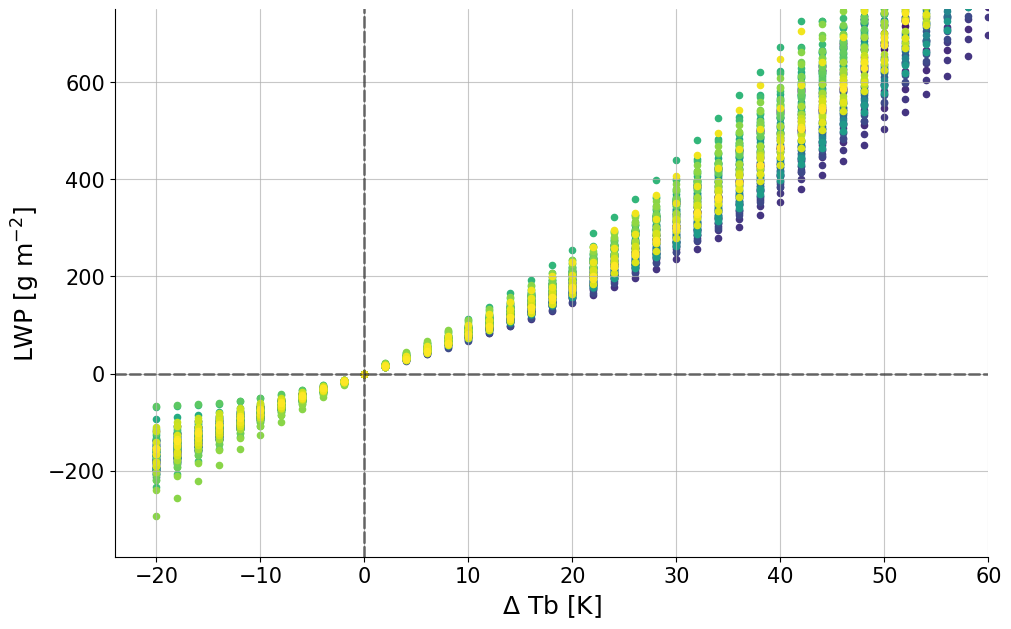

In [85]:
import matplotlib as mpl

fig, ax = plt.subplots()

fig.subplots_adjust(bottom=0.5)

colors = cm.get_cmap('viridis', coeffs_ds.time.size).colors

DELTA_TB = np.arange(-20,62,2)

for t,time in enumerate(coeffs_ds.time):

    a = coeffs_ds.sel(time=time,coefficients='a',drop=True).coeffs.values
    b = coeffs_ds.sel(time=time,coefficients='b',drop=True).coeffs.values
    c = coeffs_ds.sel(time=time,coefficients='c',drop=True).coeffs.values

    LWP = (a*DELTA_TB + b*DELTA_TB**2 + c*DELTA_TB**3)*1000

    ax.scatter(DELTA_TB,LWP,s=20,c=colors[t],label=t)

cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=1, vmax=coeffs_ds.time.size)

#cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
#                                norm=norm,
#                                orientation='horizontal')

#ax.legend(fontsize=10)
ax.set_ylim(top=750)
ax.set_xlim(right=60)
ax.grid(alpha=0.7)
ax.set_xlabel("$\Delta$ Tb [K]")
ax.set_ylabel("LWP [g m$^{-2}$]")
ax.axhline(y=0,linestyle='dashed',color='black',alpha=0.5)
ax.axvline(x=0,linestyle='dashed',color='black',alpha=0.5)

/tmp/ipykernel_705225/3355425207.py:5: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.5)
/tmp/ipykernel_705225/3355425207.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('magma', coeffs_ds.time.size).colors


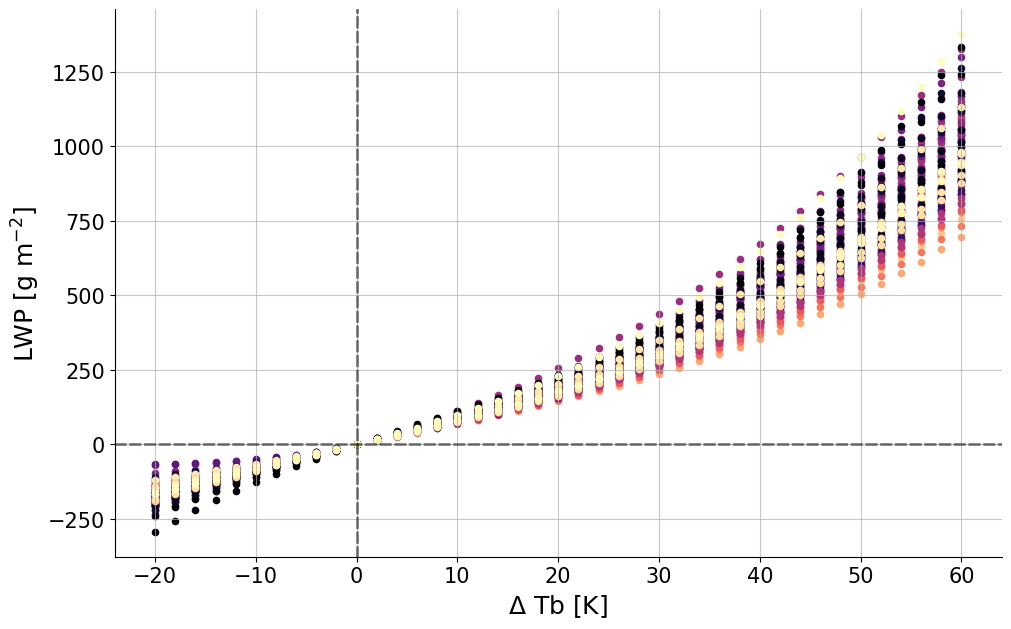

In [122]:
import matplotlib as mpl

fig, ax = plt.subplots()

fig.subplots_adjust(bottom=0.5)

colors = cm.get_cmap('magma', coeffs_ds.time.size).colors

clearsky_tbs = ctb.reindex(time=coeffs_ds.time,method='nearest').ctb.values

DELTA_TB = np.arange(-20,62,2)
LWP_arr = np.empty([coeffs_ds.time.size,len(DELTA_TB)])
ctb_arr = np.empty([coeffs_ds.time.size,len(DELTA_TB)])
for t,time in enumerate(coeffs_ds.time):

    a = coeffs_ds.sel(time=time,coefficients='a',drop=True).coeffs.values
    b = coeffs_ds.sel(time=time,coefficients='b',drop=True).coeffs.values
    c = coeffs_ds.sel(time=time,coefficients='c',drop=True).coeffs.values

    LWP = (a*DELTA_TB + b*DELTA_TB**2 + c*DELTA_TB**3)*1000
    LWP_arr[t,:] = LWP
    ctb_arr[t,:] = clearsky_tbs[t]

    ax.scatter(DELTA_TB,LWP,s=20,color=colors[np.argsort(clearsky_tbs)[t]])

cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=1, vmax=coeffs_ds.time.size)

#cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
#                                norm=norm,
#                                orientation='horizontal')

#ax.legend(fontsize=10)
#ax.set_ylim(top=750)
#ax.set_xlim(right=60)
ax.grid(alpha=0.7)
ax.set_xlabel("$\Delta$ Tb [K]")
ax.set_ylabel("LWP [g m$^{-2}$]")
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.axhline(y=0,linestyle='dashed',color='black',alpha=0.5)
ax.axvline(x=0,linestyle='dashed',color='black',alpha=0.5)


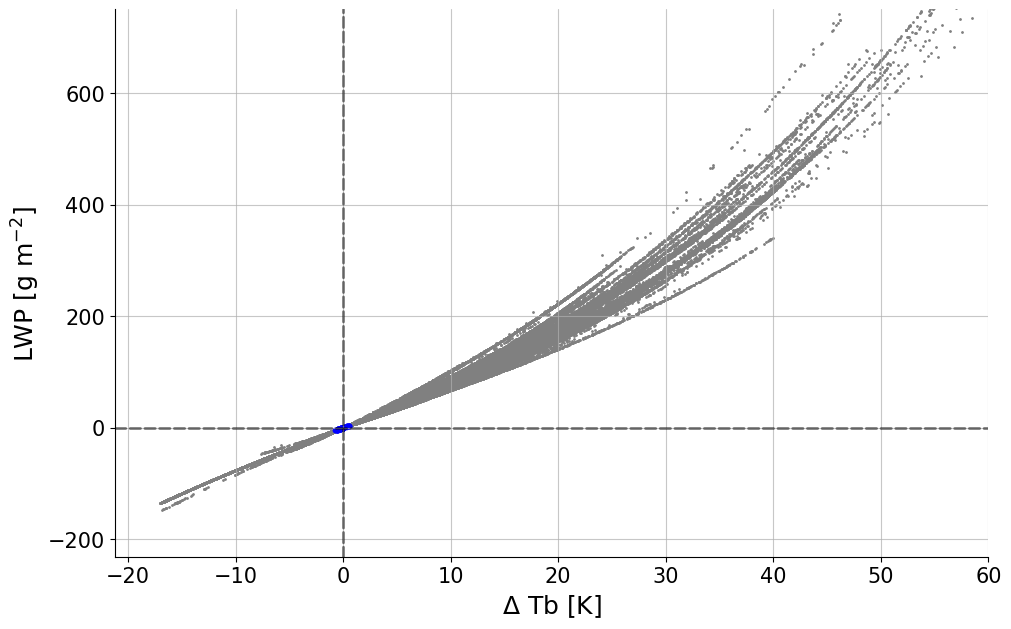

In [71]:
fig, ax = plt.subplots()

ax.scatter(delta_tb.data,lwp.lwp.values*1000,s=1,c='grey')

ds_ind_time = np.where(coeffs_ds_reindexed.sel(coefficients='a').coeffs.values==coeffs_a[14])[0]
ax.scatter(delta_tb.isel(time=ds_ind_time).data,lwp.isel(time=ds_ind_time).lwp.values*1000,s=10,color='blue')

ds_ind_time = np.where(coeffs_ds_reindexed.sel(coefficients='a').coeffs.values==coeffs_a[72])[0]
#ax.scatter(delta_tb.isel(time=ds_ind_time).data,lwp.isel(time=ds_ind_time).lwp.values*1000,s=10,color='red')

ax.set_ylim(top=750)
ax.set_xlim(right=60)
ax.grid(alpha=0.7)
ax.set_xlabel("$\Delta$ Tb [K]")
ax.set_ylabel("LWP [g m$^{-2}$]")
ax.axhline(y=0,linestyle='dashed',color='black',alpha=0.5)
ax.axvline(x=0,linestyle='dashed',color='black',alpha=0.5)

#plt.savefig('/home/mringel/lwp_project/figures/correlation_deltaTB_LWP.png',
#            bbox_inches='tight',
#            dpi=200)

## Scatterplot with dropsonde ID

/tmp/ipykernel_705225/1993834813.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('viridis', 52).colors


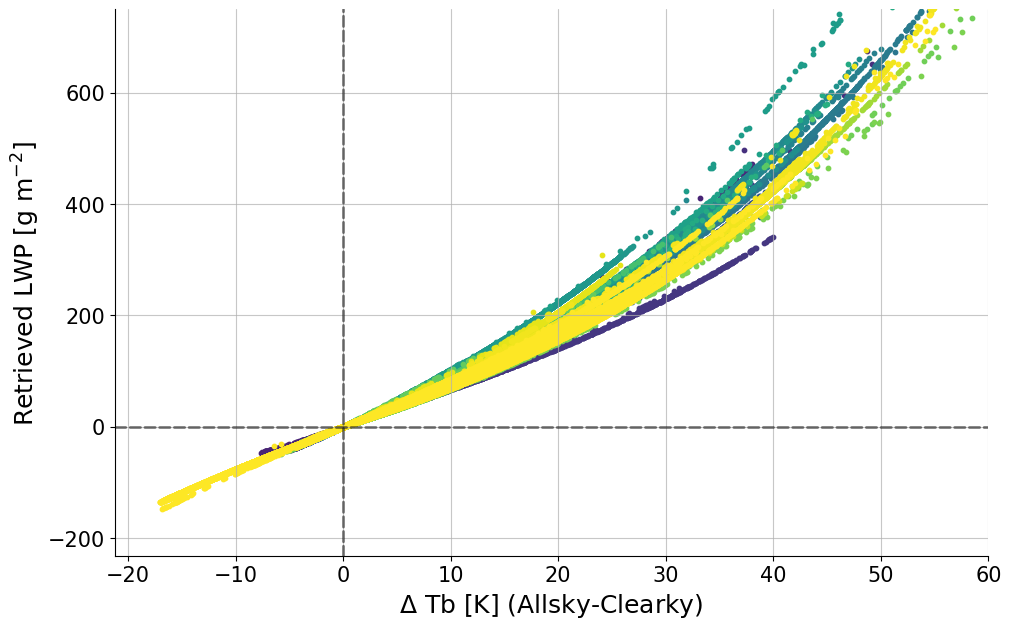

In [8]:
fig, ax = plt.subplots()

colors = cm.get_cmap('viridis', 52).colors

counter = 0
for ds_ind,time in enumerate(coeffs_ds.time):
    
    ds_ind_time = coeffs_ds_reindexed.where(coeffs_ds_reindexed.coeffs==coeffs_a[ds_ind],drop=True).time.values

    if len(ds_ind_time) > 0:
        counter += 1
        ax.scatter(delta_tb.sel(time=ds_ind_time).data,lwp.sel(time=ds_ind_time).lwp.values*1000,s=10,color=colors[counter])

ax.set_ylim(top=750)
ax.set_xlim(right=60)
ax.grid(alpha=0.7)
ax.set_xlabel("$\Delta$ Tb [K] (Allsky-Clearky)")
ax.set_ylabel("Retrieved LWP [g m$^{-2}$]")
ax.axhline(y=0,linestyle='dashed',color='black',alpha=0.5)
ax.axvline(x=0,linestyle='dashed',color='black',alpha=0.5)

#plt.savefig('/home/mringel/lwp_project/figures/correlation_deltaTB_LWP_sortby_DS.png',
#            bbox_inches='tight',
#            dpi=200)

## Scatterplot with dropsonde Temperature

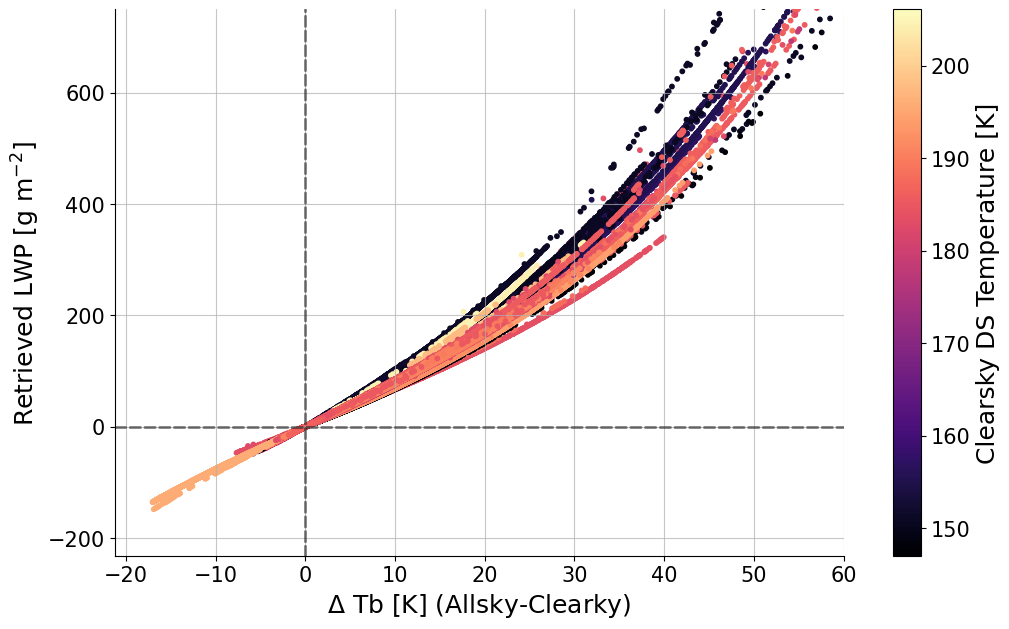

In [110]:
fig, ax = plt.subplots()

sc_cm = ax.scatter(delta_tb.data,lwp.lwp.values*1000,s=10,c=ctb.ctb.values,cmap='magma')
ax.set_ylim(top=750)
ax.set_xlim(right=60)
ax.grid(alpha=0.7)
ax.set_xlabel("$\Delta$ Tb [K] (Allsky-Clearky)")
ax.set_ylabel("Retrieved LWP [g m$^{-2}$]")
ax.axhline(y=0,linestyle='dashed',color='black',alpha=0.5)
ax.axvline(x=0,linestyle='dashed',color='black',alpha=0.5)
plt.colorbar(sc_cm,label='Clearsky DS Temperature [K]')

#plt.savefig('/home/mringel/lwp_project/figures/correlation_deltaTB_LWP_sortby_CTB.png',
#            bbox_inches='tight',
#            dpi=200)

## Scatterplot with dropsonde SST

In [ ]:
SST = cat['ACLOUD']['P5']['ESA_CCI_SST']['ACLOUD_P5_RF04'](storage_options=kwds).to_dask()

for campaign in list(cat):
    if campaign in ['PAMARCMiP','HAMAG']: continue
    for flight_id in list(cat[campaign][platform]['MiRAC-A']):
            if flight_id in ['ACLOUD_P5_RF04']: continue

            SST_i = cat[campaign][platform]['ESA_CCI_SST'][flight_id](storage_options=kwds).to_dask()

            SST = xr.concat([SST,SST_i],dim='time')

SST = SST.sel(time=delta_tb.time,drop=True)

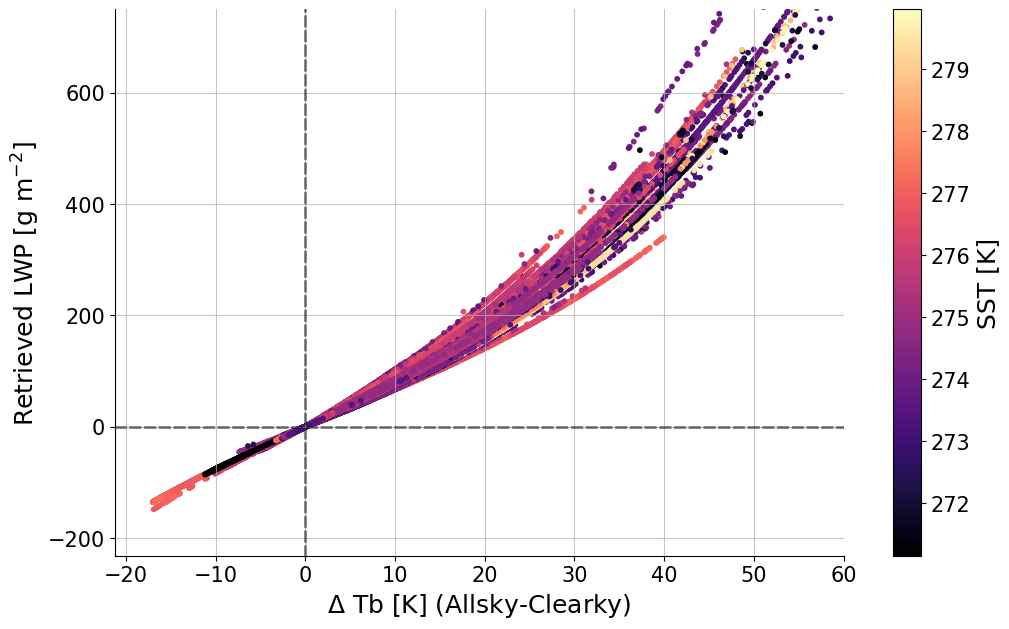

In [124]:
fig, ax = plt.subplots()

sc_cm = ax.scatter(delta_tb.data,lwp.lwp.values*1000,s=10,c=SST.sst.values,cmap='magma')
ax.set_ylim(top=750)
ax.set_xlim(right=60)
ax.grid(alpha=0.7)
ax.set_xlabel("$\Delta$ Tb [K] (Allsky-Clearky)")
ax.set_ylabel("Retrieved LWP [g m$^{-2}$]")
ax.axhline(y=0,linestyle='dashed',color='black',alpha=0.5)
ax.axvline(x=0,linestyle='dashed',color='black',alpha=0.5)
plt.colorbar(sc_cm,label='SST [K]')

#plt.savefig('/home/mringel/lwp_project/figures/correlation_deltaTB_LWP_sortby_SST.png',
#            bbox_inches='tight',
#            dpi=200)

## Scatterplot with dropsondes sorted by campaigns

/tmp/ipykernel_4090700/3021426328.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[i]._sizes = [50]


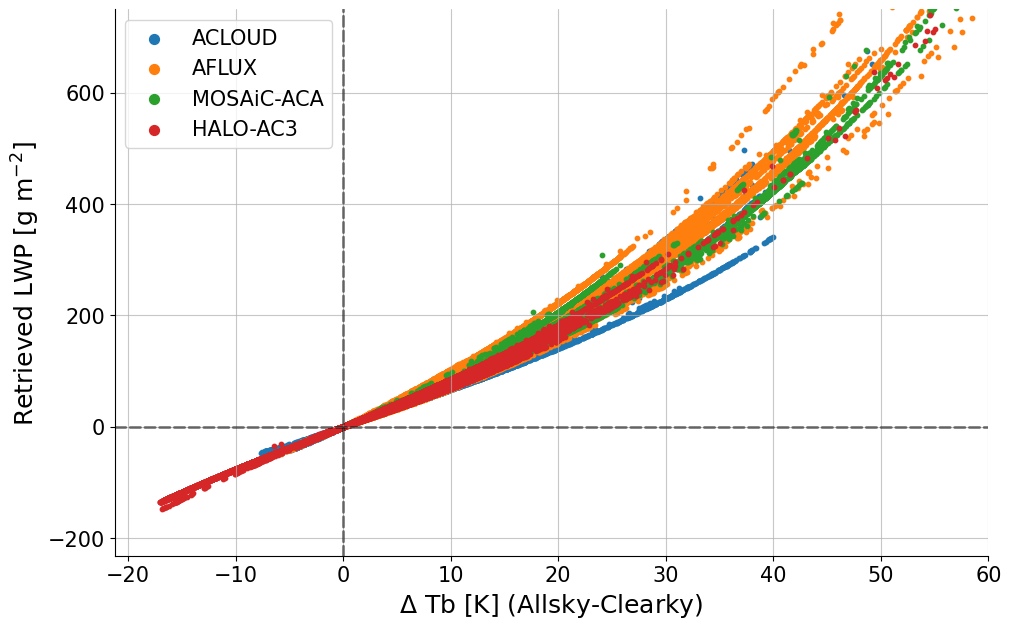

In [113]:
fig, ax = plt.subplots()

platform = 'P5'
for campaign in list(cat):
    if campaign in ['PAMARCMiP','HAMAG']: continue
    
    flight_ids = list(cat[campaign][platform]['MiRAC-A'])

    start_date = meta[campaign]['P5'][flight_ids[0]]['date']
    end_date = meta[campaign]['P5'][flight_ids[-1]]['date']

    ax.scatter(delta_tb.sel(time=slice(start_date,end_date)).data,
               lwp.sel(time=slice(start_date,end_date)).lwp.values*1000,s=10,label=campaign)

lgnd = ax.legend()
ax.set_ylim(top=750)
ax.set_xlim(right=60)
ax.grid(alpha=0.7)
ax.set_xlabel("$\Delta$ Tb [K] (Allsky-Clearky)")
ax.set_ylabel("Retrieved LWP [g m$^{-2}$]")
ax.axhline(y=0,linestyle='dashed',color='black',alpha=0.5)
ax.axvline(x=0,linestyle='dashed',color='black',alpha=0.5)

for i in range(4):
    lgnd.legendHandles[i]._sizes = [50]

#plt.savefig('/home/mringel/lwp_project/figures/correlation_deltaTB_LWP_sortby_campaign.png',
#            bbox_inches='tight',
#            dpi=200)

In [139]:
for i,campaign in enumerate(['ACLOUD','AFLUX','MOSAiC-ACA','HALO-AC3']):
    
    flight_ids = list(cat[campaign][platform]['MiRAC-A'])

    start_date = meta[campaign]['P5'][flight_ids[0]]['date']
    end_date = meta[campaign]['P5'][flight_ids[-1]]['date']

    
    coeffs_ds_slice = coeffs_ds.sel(time=slice(start_date,end_date),drop=True)

    print(len(coeffs_ds_slice.time))

52
28
7
0


/tmp/ipykernel_705225/2312602195.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('viridis', 4).colors


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


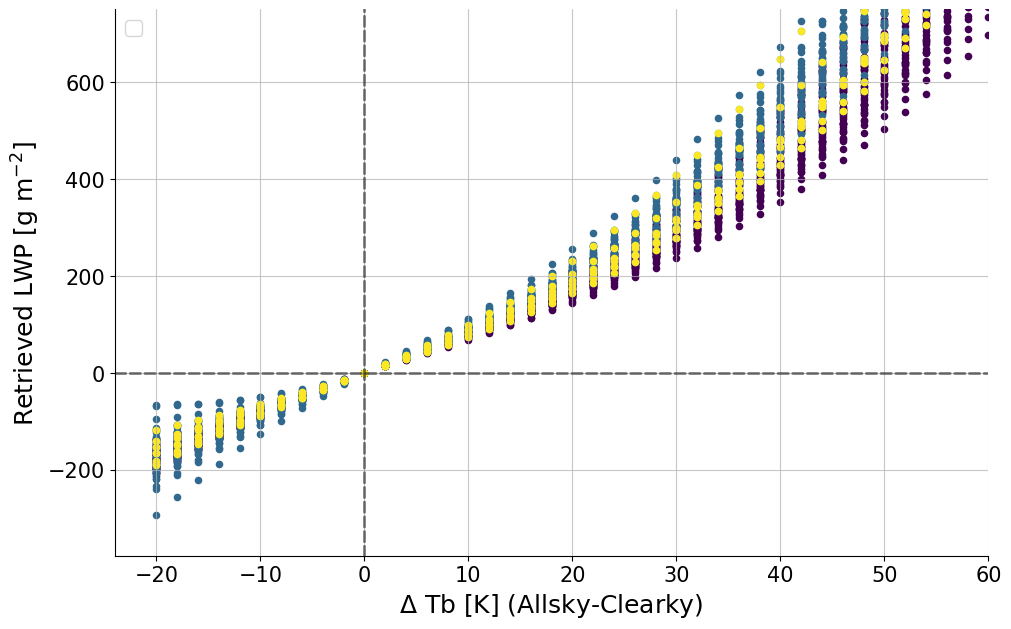

In [138]:
fig, ax = plt.subplots()

platform = 'P5'
colors = cm.get_cmap('viridis', 4).colors
for i,campaign in enumerate(['ACLOUD','AFLUX','MOSAiC-ACA','HALO-AC3']):
    
    flight_ids = list(cat[campaign][platform]['MiRAC-A'])

    start_date = meta[campaign]['P5'][flight_ids[0]]['date']
    end_date = meta[campaign]['P5'][flight_ids[-1]]['date']

    if campaign != 'HALO-AC3':
        coeffs_ds_slice = coeffs_ds.sel(time=slice(start_date,end_date),drop=True)

    for t,time in enumerate(coeffs_ds_slice.time):

        a = coeffs_ds_slice.sel(time=time,coefficients='a',drop=True).coeffs.values
        b = coeffs_ds_slice.sel(time=time,coefficients='b',drop=True).coeffs.values
        c = coeffs_ds_slice.sel(time=time,coefficients='c',drop=True).coeffs.values

        LWP = (a*DELTA_TB + b*DELTA_TB**2 + c*DELTA_TB**3)*1000

        ax.scatter(DELTA_TB,LWP,s=20,color=colors[i])

lgnd = ax.legend()
ax.set_ylim(top=750)
ax.set_xlim(right=60)
ax.grid(alpha=0.7)
ax.set_xlabel("$\Delta$ Tb [K] (Allsky-Clearky)")
ax.set_ylabel("Retrieved LWP [g m$^{-2}$]")
ax.axhline(y=0,linestyle='dashed',color='black',alpha=0.5)
ax.axvline(x=0,linestyle='dashed',color='black',alpha=0.5)

#for i in range(4):
#    lgnd.legendHandles[i]._sizes = [50]

#plt.savefig('/home/mringel/lwp_project/figures/correlation_deltaTB_LWP_sortby_campaign.png',
#            bbox_inches='tight',
#            dpi=200)

In [132]:
# go over every clearsky dropsonde timestamp, get corresponding dropsonde datatset
# and calculate basic mean values of mixing ratio, relative humidity and 10m wind

avg_mr = np.zeros(len(coeffs_ds.time.values))
avg_rh = np.zeros(len(coeffs_ds.time.values))
wind_10m = np.zeros(len(coeffs_ds.time.values))

for i,ds_timestamp in enumerate(coeffs_ds.time.values):

    Y = np.datetime_as_string(ds_timestamp)[0:4]
    M = np.datetime_as_string(ds_timestamp)[5:7]
    D = np.datetime_as_string(ds_timestamp)[8:10]
    hour = np.datetime_as_string(ds_timestamp)[11:13]
    min = np.datetime_as_string(ds_timestamp)[14:16]
    sec = np.datetime_as_string(ds_timestamp)[17:19]

    if Y == '2017':
        campaign = 'acloud'
    if Y == '2019':
        campaign = 'aflux'
    if Y == '2020':
        campaign = 'mosaic-aca'
    if Y == '2022':
        campaign = 'halo-ac3'

    ds_list = sorted(glob.glob(f'/data/obs/campaigns/{campaign}/p5/dropsondes/{Y}/{M}/{D}/D{Y}{M}{D}_{hour}{min}*_PQC.nc'))
    if len(ds_list) > 1: 
        print("More than one file found!")
        
    if len(ds_list) == 0: 
        print("No file found!")
        continue

    clearsky_ds = xr.open_dataset(ds_list[0])

    avg_mr[i] = clearsky_ds.mr.mean(dim='time').values
    avg_rh[i] = clearsky_ds.mr.mean(dim='time').values
    wind_10m[i] = clearsky_ds.wspd.values[np.nanargmin(np.abs(clearsky_ds.gpsalt.values - 10.))]


No file found!
No file found!


/net/secaire/mringel/.conda/envs/ac3env/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/net/secaire/mringel/.conda/envs/ac3env/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/net/secaire/mringel/.conda/envs/ac3env/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/net/secaire/mringel/.conda/envs/ac3env/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/net/secaire/mringel/.conda/envs/ac3env/lib/python3.10/site-packages/xarray/coding/times.py:254:

### Scatterplot with average dropsonde humidity

/tmp/ipykernel_215272/506912190.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('viridis', len(coeffs_ds.time)).colors


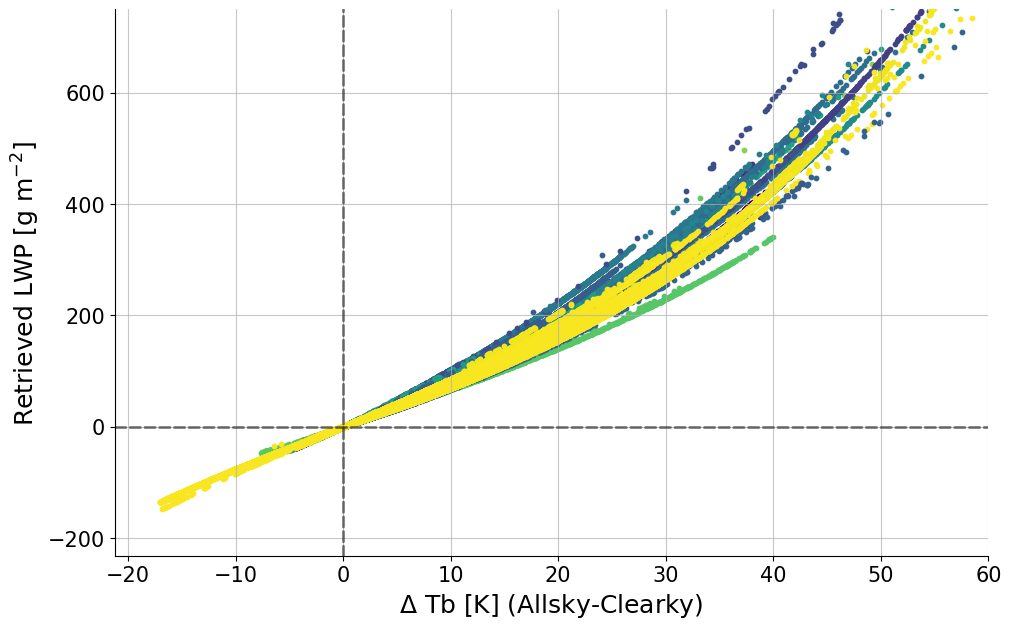

In [148]:
coeffs_a = coeffs_ds.sel(coefficients='a').coeffs.values

fig, ax = plt.subplots()

colors = cm.get_cmap('viridis', len(coeffs_ds.time)).colors

counter = 0
for ds_ind,time in enumerate(coeffs_ds.time):
    
    ds_ind_time = coeffs_ds_reindexed.where(coeffs_ds_reindexed.coeffs==coeffs_a[ds_ind],drop=True).time.values

    if len(ds_ind_time) > 0:
        counter += 1
        if avg_rh[ds_ind] != 0:
            ax.scatter(delta_tb.sel(time=ds_ind_time).data,lwp.sel(time=ds_ind_time).lwp.values*1000,s=10,color=colors[np.argsort(avg_rh)[ds_ind]])
        #if avg_rh[ds_ind] == 0:
        #    ax.scatter(delta_tb.sel(time=ds_ind_time).data.compute(),lwp.sel(time=ds_ind_time).lwp.values*1000,s=10,color='grey')

ax.set_ylim(top=750)
ax.set_xlim(right=60)
ax.grid(alpha=0.7)
ax.set_xlabel("$\Delta$ Tb [K] (Allsky-Clearky)")
ax.set_ylabel("Retrieved LWP [g m$^{-2}$]")
ax.axhline(y=0,linestyle='dashed',color='black',alpha=0.5)
ax.axvline(x=0,linestyle='dashed',color='black',alpha=0.5)

#plt.savefig('/home/mringel/lwp_project/figures/correlation_deltaTB_LWP_sortby_RH.png',
#            bbox_inches='tight',
#            dpi=200)

### Scatterplot with dropsonde 10m wind

/tmp/ipykernel_215272/3686374861.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('viridis', len(coeffs_ds.time)).colors


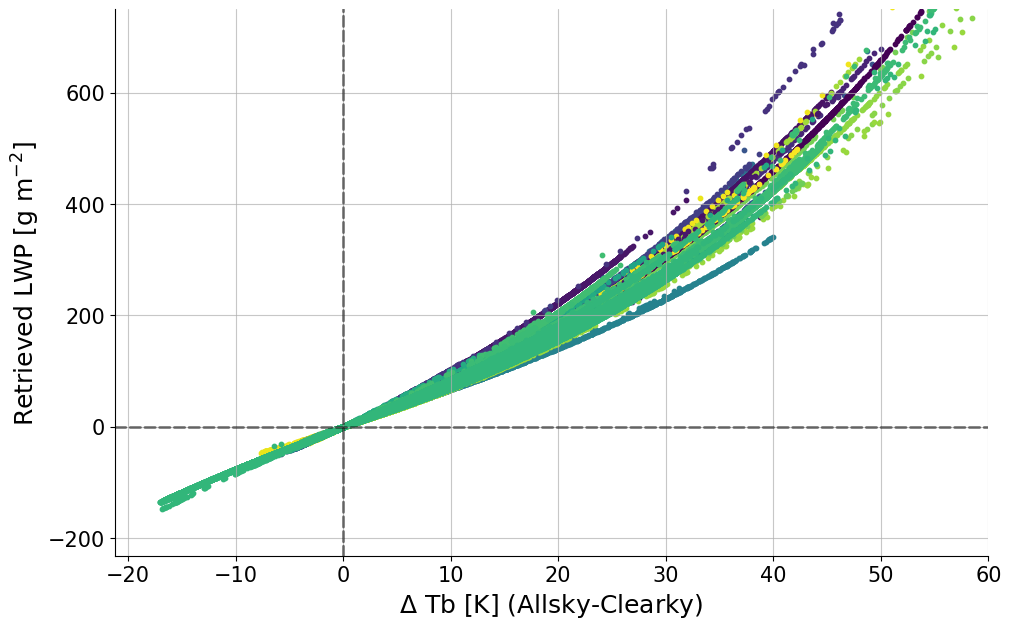

In [151]:
coeffs_a = coeffs_ds.sel(coefficients='a').coeffs.values

fig, ax = plt.subplots()

colors = cm.get_cmap('viridis', len(coeffs_ds.time)).colors

counter = 0
for ds_ind,time in enumerate(coeffs_ds.time):
    
    ds_ind_time = coeffs_ds_reindexed.where(coeffs_ds_reindexed.coeffs==coeffs_a[ds_ind],drop=True).time.values

    if len(ds_ind_time) > 0:
        counter += 1
        if wind_10m[ds_ind] != 0:
            ax.scatter(delta_tb.sel(time=ds_ind_time).data,lwp.sel(time=ds_ind_time).lwp.values*1000,s=10,color=colors[np.argsort(wind_10m)[ds_ind]])
        #if avg_rh[ds_ind] == 0:
        #    ax.scatter(delta_tb.sel(time=ds_ind_time).data.compute(),lwp.sel(time=ds_ind_time).lwp.values*1000,s=10,color='grey')

ax.set_ylim(top=750)
ax.set_xlim(right=60)
ax.grid(alpha=0.7)
ax.set_xlabel("$\Delta$ Tb [K] (Allsky-Clearky)")
ax.set_ylabel("Retrieved LWP [g m$^{-2}$]")
ax.axhline(y=0,linestyle='dashed',color='black',alpha=0.5)
ax.axvline(x=0,linestyle='dashed',color='black',alpha=0.5)

plt.savefig('/home/mringel/lwp_project/figures/correlation_deltaTB_LWP_sortby_wspd10.png',
            bbox_inches='tight',
            dpi=200)

In [ ]:
#